In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from GaussianGenerativeModel import GaussianGenerativeModel as GGM
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from util import write_predictions
import os
# seaborn is a way to make our plots not look like shit
try:
    import seaborn as sns
except:
    pass
%matplotlib inline

In [160]:
# Use with train data
data = pd.read_csv("data/featuresFromStrings.csv")
data = data.drop(['id'], axis = 1)

In [141]:
# Use with test data
data = pd.read_csv("data/featuresFromStrings.csv")
test_data = pd.read_csv("data/featuresFromStringsTest.csv")
# data = data.drop(['id'], axis = 1)

In [149]:
data.shape

(3086, 24)

In [150]:
test_data.shape

(3724, 24)

In [129]:
def calcAccuracy(pred, obs):
    assert (pred.shape[0] == obs.shape[0])
    correct = 0
    for i in xrange(pred.shape[0]):
        if pred[i] == obs[i]:
            correct += 1
    return 100.0 * correct / pred.shape[0]

In [130]:
def crossValidation(n, model, data, prnt=True):
    """
    n: number of cross validation folds
    model: model that we will use. Must have model.fit and model.predict
    prnt: whether or not to print results, bool
    """
    # Determines size of blocks
    dataSize = data.shape[0]
    blockSize = dataSize / n
    
    # Percent correct
    accuracy = []
    
    for i in xrange(n):
        if prnt:
            print i,
        # Calculate start and end indices of validation data
        start = i * blockSize
        end = start + blockSize
        
        # Training and test data
        featsTrain = pd.concat((data.iloc[0:start], data.iloc[end:dataSize]), axis=0)
        featsTest = data.iloc[start:end]
        
        # Store classes
        classTrain = featsTrain.classnum.values
        featsTrain = featsTrain.drop(['classnum'], axis = 1)
        classTest = featsTest.classnum.values
        featsTest = featsTest.drop(['classnum'], axis = 1)
        
        # Training / testing values
        valsTrain = featsTrain.values
        valsTest = featsTest.values
        
        # Classifier goes here
        C = model
        C.fit(valsTrain, classTrain)
        classPred = C.predict(valsTest)
        
        # Calculate accuracy
        accuracy.append(calcAccuracy(classPred, classTest))
    if prnt:   
        print ""  # this is to make a new line
        print "Mean: " + str(np.mean(accuracy))
        print "Variance: " + str(np.var(accuracy))
        print "Std Dev: " + str(np.std(accuracy))
    return np.mean(accuracy)

In [165]:
def test_n_estimators(n, model, estimators, data, title):
    """
    Tests and plots a number of estimators on a model
    n: number of folds for cross validation
    model: model to fit/predict
    estimators: array of potential estimator values for plotting
    """
    results = []
    
    for e in estimators:
        print e,
        m = model(n_estimators=e)
        results.append(crossValidation(n, m, data, prnt=False))
        
    plt.plot(estimators, results)
    plt.title(title)
    plt.xlabel("N Estimators")
    plt.ylabel("Model Accuracy")

In [ ]:
crossValidation(20, GGM())

In [ ]:
# Gausian naieve bayes model
GNB = GaussianNB()
crossValidation(20, GNB)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Mean: 89.4480519481
Variance: 5.39192949907
Std Dev: 2.32205286311
2 5 10 20 30 40 50 70 90


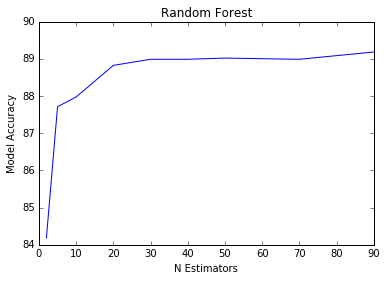

In [167]:
# random forest classifier
RF = RandomForestClassifier(n_estimators=40)
crossValidation(20, RF, data)
test_n_estimators(30, RandomForestClassifier, [2, 5, 10, 20, 30, 40, 50, 70, 90], data, title="Random Forest")

In [ ]:
# adaboost classifier
AB = AdaBoostClassifier()
crossValidation(20, AB)
test_n_estimators(20, AdaBoostClassifier, [2, 5, 10, 20, 30, 40, 50, 70, 90], title="AdaBoost")

In [ ]:
# bagging classifier
BG = BaggingClassifier()
crossValidation(20, BG)
test_n_estimators(20, BaggingClassifier, [2, 5, 10, 20, 30, 40, 50, 70, 90], title="Bagging")

In [168]:
# extra trees classifier
ET = ExtraTreesClassifier(n_estimators=40)
crossValidation(20, ET, data)
# test_n_estimators(20, ExtraTreesClassifier, [2, 5, 10, 20, 30, 40, 50, 70, 90], data, title="Extra Trees")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Mean: 88.9285714286
Variance: 4.99557260921
Std Dev: 2.23507776357


88.928571428571416

### Creating Predictions

In [155]:
def predict_export(train_df, test_df, model, outfile):
    """
    Fits the training data to the model, predicts, and exports the
    predictions in kaggle-approved format to csv
    ----------
    train_df: training pd dataframe
    test_df: test pd dataframe, with classnum column and id as index
    model: model to fit/predict
    outfile: path string for output csv
    """
    y_train = train_df["classnum"].values
    X_train = train_df.drop("classnum", axis=1).drop("id", axis=1).values
    
    test_ids = test_df.id.values
    X_test = test_df.drop("classnum", axis=1).drop("id", axis=1).values
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    write_predictions(preds, test_ids, outfile)

In [158]:
RF = RandomForestClassifier(n_estimators=40)

# Increment the number each time to save all predictions!
predict_export(data, test_data, RF, "predictions/RFpredictions2.csv")